# Powering Through

**Name(s)**: Andrea González Martín & Andrés Riera Ortiz

**Website Link**: https://andiigonzalez.github.io/Power_Outage_Analysis/index.html

In [195]:

import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'
import matplotlib as plt

from dsc80_utils import * 

## Step 1: Introduction

In [196]:
# Open the csv file and drop columns that are not needed for the analysis
#pd.set_option('display.max_columns', None) # display all columns of the dataframe 
outages = pd.read_csv('/Users/andigonzalez/Desktop/DSC80/Power_Outage_Analysis/outages.csv') # read the csv file
outages.drop(['POSTAL.CODE', 'HURRICANE.NAMES', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME', 'RES.PRICE','COM.PRICE', 'IND.PRICE', 'TOTAL.PRICE','RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN','COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUSTOMERS', 'RES.CUST.PCT', 'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA', 'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP', 'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPPCT_UC', 'POPDEN_UC', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT', 'PCT_WATER_INLAND', 'AREAPCT_URBAN','POPPCT_URBAN' ], axis=1, inplace=True)


In [197]:
# Save the top rows of dataframe head an html file to include in the webpage
html_file = "/Users/andigonzalez/Desktop/DSC80/Power_Outage_Analysis/assets/images/outages_head.html"
outages.head(10).to_html(html_file, index=False)


## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning

In [198]:
# Clean categorical values of leading or trailing spaces 

outages = outages.rename(columns={'U.S._STATE': 'STATE'})
outages['STATE'] = outages['STATE'].str.strip()
outages['NERC.REGION'] = outages['NERC.REGION'].str.strip()
outages['CLIMATE.REGION'] = outages['CLIMATE.REGION'].str.strip()
outages['CLIMATE.CATEGORY'] = outages['CLIMATE.CATEGORY'].str.strip()
outages['CAUSE.CATEGORY'] = outages['CAUSE.CATEGORY'].str.strip()
outages['CAUSE.CATEGORY.DETAIL'] = outages['CAUSE.CATEGORY.DETAIL'].str.strip()
outages.columns = outages.columns.str.strip() 
outages.columns



Index(['OBS', 'YEAR', 'MONTH', 'STATE', 'NERC.REGION', 'CLIMATE.REGION',
       'ANOMALY.LEVEL', 'CLIMATE.CATEGORY', 'OUTAGE.START.DATE',
       'OUTAGE.START.TIME', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL',
       'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'RES.SALES',
       'COM.SALES', 'IND.SALES', 'TOTAL.SALES', 'POPULATION', 'POPDEN_URBAN',
       'POPDEN_RURAL'],
      dtype='object')

In [199]:
# combine dates and times into a single column.
outages['OUTAGE.START'] = outages['OUTAGE.START.DATE'] + " " + outages['OUTAGE.START.TIME']
# reformat variables to datetime format
outages['OUTAGE.START'] = pd.to_datetime(outages['OUTAGE.START'], format='%Y-%m-%d %H:%M:%S')
# drop date and time columns 
outages = outages.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME'])
outages.columns


Index(['OBS', 'YEAR', 'MONTH', 'STATE', 'NERC.REGION', 'CLIMATE.REGION',
       'ANOMALY.LEVEL', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY',
       'CAUSE.CATEGORY.DETAIL', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW',
       'CUSTOMERS.AFFECTED', 'RES.SALES', 'COM.SALES', 'IND.SALES',
       'TOTAL.SALES', 'POPULATION', 'POPDEN_URBAN', 'POPDEN_RURAL',
       'OUTAGE.START'],
      dtype='object')

In [200]:
# Replace/Substitute values of 0 in columns OUTAGE.DURATION, DEMAND.LOSS.MW, and CUSTOMERS.AFFECTED
outages['OUTAGE.DURATION'] = outages['OUTAGE.DURATION'].replace(0, np.nan)
outages['DEMAND.LOSS.MW'] = outages['DEMAND.LOSS.MW'].replace(0, np.nan)
outages['CUSTOMERS.AFFECTED'] = outages['CUSTOMERS.AFFECTED'].replace(0, np.nan)
outages['CAUSE.CATEGORY'].unique()



array(['severe weather', 'intentional attack',
       'system operability disruption', 'equipment failure',
       'public appeal', 'fuel supply emergency', 'islanding'],
      dtype=object)

### Univariate Analysis

In [201]:
import matplotlib.pyplot as plt
import plotly.express as px 
# Group data by year to produce a univariate analysis of the number of outages per year. Create a bar plot with the corresponding data.
outages_by_year = outages.groupby('YEAR').count()['OBS']
outages_by_year_df = outages_by_year.reset_index()
fig = px.bar(outages_by_year_df, x='YEAR', y='OBS', title='Number of Power Outages by Year', labels={'YEAR': 'Year', 'OBS': 'Number of Outages'}, color_discrete_sequence=['orange'])

# Customize layout
fig.update_layout(
    title={
        'text': 'Number of Power Outages by Year',
        'x': 0.5,  # Center the title
        'y': 0.98,  # Add padding above the plot
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')  # Custom font for title
    },
    xaxis_title_font=dict(size=14),  # Font size for x-axis title
    yaxis_title_font=dict(size=14),  # Font size for y-axis title
    xaxis=dict(tickmode='linear'),  # Ensure all years are displayed
    width=700,  # Make the plot wider
    height=300   # Adjust height if needed
)

# Show the plot
fig.show()
pio.write_html(fig, file='assets/images/outages_by_year.html', auto_open=False)


In [202]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame (replace this with your actual data)
# outages = pd.read_csv('outages_data.csv')

outages2 = outages.dropna(subset=['CAUSE.CATEGORY'])
# Group data by cause and count the number of occurrences
cause_counts = outages2.groupby('CAUSE.CATEGORY').size()

# Create interactive pie chart with Plotly
fig = go.Figure(data=[go.Pie(
    labels=cause_counts.index.str.capitalize(), 
    values=cause_counts.values,
    textinfo='percent+label',
    textposition='inside',
    textfont=dict(size=14, family='Arial, Helvetica, sans-serif'),
    hoverinfo='label+percent')])

# Customize layout with explicit sans-serif font
fig.update_layout(
    title={
        'text': 'Distribution of Power Outages by Cause from 2000 to 2016',
        'font': {'size': 20, 'family': 'Arial, Helvetica, sans-serif' } },
        font=dict(family='Arial, Helvetica, sans-serif'))
fig.show()
# Save as interactive HTML file
fig.write_html('assets/images/distribution_of_power_outage_cause.html', auto_open=False)

In [203]:
# Group data by state variable to produce a univariate analysis of the number of total outages per state

outages_by_state = outages.groupby('STATE').count()['OBS'].reset_index()
outages_by_state_plot = px.line(outages_by_state, x='STATE', y='OBS', title='Number of Power Outages by State from 2000 to 2016', labels={'STATE': 'State', 'OBS': 'Number of Outages'}, color_discrete_sequence=['skyblue'])

outages_by_state_plot.update_layout(
    title={
        'text': 'Number of Power Outages by State from 2000 to 2016',
        'x': 0.5,  # Center the title
        'y': 0.98,  # Add padding above the plot
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')  # Custom font for title
    },
    xaxis_title_font=dict(size=14),  # Font size for x-axis title
    yaxis_title_font=dict(size=14),  # Font size for y-axis title
    xaxis=dict(tickmode='linear'),  # Ensure all years are displayed
    yaxis=dict(
        tickmode='array',  # Specify custom tick values
        tickvals=list(range(0, outages_by_state['OBS'].max() + 50, 50)),  # Ticks at 50 increments
        title='Number of Outages'
    ),
    width=800,  # Make the plot wider
    height=400   # Adjust height if needed
)

# Show the plot
outages_by_state_plot.show()
pio.write_html(outages_by_state_plot, file='assets/images/outages_by_state.html', auto_open=False)


### Bivariate Analysis

#### Bivariate Analysis #1: Interactive Map of Power Outages Experienced By Climate Regions


In [204]:
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go

# Create a dictionary mapping regions to their states
region_states = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Southeast': ['FL', 'GA', 'AL', 'NC', 'SC', 'VA'],
    'Central': ['IL', 'MO', 'IN', 'KY', 'WV', 'OH', 'TN'],
    'Southwest': ['AZ', 'CO', 'UT', 'NM'],
    'West': ['NV', 'CA'],
    'Northwest': ['OR', 'WA', 'ID'],
    'South': ['KS', 'TX', 'OK', 'LA', 'AR', 'MS'],
    'West North Central': ['ID', 'MT', 'NE', 'ND', 'SD', 'WY'],
    'East North Central': ['MN', 'IA', 'WI', 'MI']
}

# Outages data
outages_data = {
    'Region': ['Central', 'East North Central', 'Northeast', 'Northwest', 
               'South', 'Southeast', 'Southwest', 'West', 
               'West North Central'],
    'Outages': [200, 138, 350, 132, 229, 153, 92, 217, 17]
}

# Create DataFrame
flattened_data = [(region, state) for region, states in region_states.items() for state in states]
df_regions = pd.DataFrame(flattened_data, columns=['Region', 'State'])

# Convert outages_data to a DataFrame
df_outages = pd.DataFrame(outages_data)

# Merge the regions DataFrame with the outages data
merged_df = df_regions.merge(df_outages, on='Region', how='left')
region_centers = {
    'Northeast': {'lat': 42.0, 'lon': -72.0},
    'Southeast': {'lat': 33.0, 'lon': -84.0},
    'Central': {'lat': 39.0, 'lon': -88.0},
    'Southwest': {'lat': 36.0, 'lon': -108.0},
    'West': {'lat': 37.0, 'lon': -119.0},
    'Northwest': {'lat': 45.0, 'lon': -120.0},
    'South': {'lat': 33.0, 'lon': -97.0},
    'West North Central': {'lat': 45.0, 'lon': -105.0},
    'East North Central': {'lat': 43.0, 'lon': -89.0}
}

# Create a base choropleth map
fig = px.choropleth(
    merged_df,
    locations="State",                # The column with state abbreviations
    locationmode="USA-states",        # Map mode for US states
    color="Outages",                  # Color by the total outages in the region
    hover_name="Region",              # Display the region name on hover
    title="Regional Outages in the USA",
    scope="usa",                      # Limit map to USA
    color_continuous_scale=px.colors.sequential.Plasma
)

# Add annotations for region names


# Update layout to ensure sans-serif font for the plot text
fig.update_layout(
    font=dict(family="sans-serif")  # Set the font family for the whole plot to sans-serif
)

# Show the map
fig.show()
pio.write_html(fig, file='assets/images/outages_by_region_map.html', auto_open=False)

#### Bivariate Analysis #2: Stacked Bar Plot of Quantifying the Number of Power Outages and the Cause by Climate Region


In [205]:
import plotly.io as pio

# Create the grouped DataFrame for the plot
a = outages.groupby(['CLIMATE.REGION', 'CAUSE.CATEGORY']).count()['OBS']
df = a.reset_index()
df['CAUSE.CATEGORY'] = df['CAUSE.CATEGORY'].str.capitalize()
stacked_plot = px.bar(
    df,
    x='CLIMATE.REGION',
    y='OBS',
    color='CAUSE.CATEGORY'
)

# Update the layout of the plot
stacked_plot.update_layout(
    font=dict(family='Sans-serif'),
    title={
        'text': 'Number of Outages and their Cause Category per Region',
        'x': 0.4,  # Center the title horizontally
        'y': 0.98,  # Adjust vertical positioning of the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')
    },
    xaxis_title='Climate Region',  # Title for the x-axis
    yaxis_title='Number of Outages',  # Title for the y-axis
    xaxis=dict(
        title_font=dict(size=14),  # Font size for x-axis title
        tickmode='linear'
    ),
    yaxis=dict(
        title_font=dict(size=14)  # Font size for y-axis title
    ),
    legend_title_text='Cause Category',  # Legend title
    legend=dict(
        title_font=dict(size=14),  # Font size for legend title
        font=dict(size=12)  # Font size for legend items
    ),
    width=800,  # Adjust the width of the plot
    height=400   # Adjust the height of the plot
)

# Show the plot
stacked_plot.show()

# Save the plot as an HTML file
pio.write_html(stacked_plot, file='assets/images/bivariate_stacked_barplot.html', auto_open=False)


#### Bivariate Analysis #3: Stacked Bar Plot of Quantifying the Number of Power Outages and the Cause by State


In [206]:
import plotly.io as pio

# Create the grouped DataFrame for the plot
outage_causes_by_State = outages.groupby(['STATE', 'CAUSE.CATEGORY']).count()['OBS']
state_causes= outage_causes_by_State.reset_index()
state_causes['CAUSE.CATEGORY'] = state_causes['CAUSE.CATEGORY'].str.capitalize()
stacked_plot_state_cause = px.bar(
    state_causes,
    x='STATE',
    y='OBS',
    color='CAUSE.CATEGORY'
)

# Update the layout of the plot
stacked_plot_state_cause.update_layout(
    font=dict(family='Sans-serif'),
    title={
        'text': 'Number of Outages and their Cause Category per State',
        'x': 0.4,  # Center the title horizontally
        'y': 0.98,  # Adjust vertical positioning of the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')
    },
    xaxis_title='State',  # Title for the x-axis
    yaxis_title='Number of Outages',  # Title for the y-axis
    xaxis=dict(
        title_font=dict(size=14),  # Font size for x-axis title
        tickmode='linear'
    ),
    yaxis=dict(
        title_font=dict(size=14)  # Font size for y-axis title
    ),
    legend_title_text='Cause Category',  # Legend title
    legend=dict(
        title_font=dict(size=14),  # Font size for legend title
        font=dict(size=12)  # Font size for legend items
    ),
    width=800,  # Adjust the width of the plot
    height=400   # Adjust the height of the plot
)

# Show the plot
stacked_plot_state_cause.show()

# Save the plot as an HTML file
pio.write_html(stacked_plot_state_cause, file='assets/images/bivariate_stacked_barplot_by_state.html', auto_open=False)


### Aggregate Variables

#### Pivot Table #1:
1. Grouped data by `CLIMATE.REGION`, `YEAR`, and `CAUSE.CATEGORY` to see how each of the climate region's vulnerability to specific causes and the number of outages they have experienced per cause per year. 

2. Created a Pivot Table with `pd.pivot_table()` using the dataframe of grouped values we created. We also replaced missing values with 0 for readability. 

3. Added a column called `Total Outages` to calcualte the total outages per climate region per year


In [207]:
# Group data by climate region, Year and Cause Category of the Power outage. Then create a pivot table so that we can understand if there are any trends within these variables. 
b = outages.groupby(['YEAR', 'CLIMATE.REGION', 'CAUSE.CATEGORY']).count()['OBS'] # group the data by the relevant variables
df2 = b.reset_index() # reset index
df2['CAUSE.CATEGORY'] = df2['CAUSE.CATEGORY'].str.capitalize() # Capitalize the Cause categories for earier visualization and aesthetic

# Create a piuvot table
# For easier understanding, fill in missing values (NaN) as 0
pivot_table = pd.pivot_table(
    df2,
    values='OBS',
    index=['YEAR', 'CLIMATE.REGION'], # select the Multindex for the pivot table
    columns='CAUSE.CATEGORY',
    aggfunc='sum',  # Aggregation function to calculate number of outages with the same cause within each climate region and year
    fill_value=0    # Replace NaN with 0 for readability
)
# Add an extra column that computed the total jumber of outages per year per climate region
pivot_table['Total Outages'] = pivot_table.sum(axis=1)


pivot_table.to_html('assets/images/pivot_table_outages.html', border=1, col_space=100)  # Convert the pivot table to HTML and save it into my assets/images folder



#### Pivot Table #2: Total Number of Outages by Month Occurance and Cause
This pivot table is to understand the distribution of outages over the months in a year and also the relationship between certain outages causes and the month they occured in . 

1. Grouped data by `CAUSE.CATEGORY`, `CAUSE.CATEGORY.DETAIL`, and `MONTH` to see if each state's yearly consumption of electricty and number of outages have a trend or not. 

2. Created a Pivot Table with `pd.pivot_table()` using the dataframe of grouped values we created. We also replaced missing values with 0 for readability and used the aggregate function `sum` to compute the number of outages that occured in a specific month due to the same cause category and category detail.

3. Added a column called `Total Outages` to calcualte the total outages per climate region per year

In [209]:

a = outages.groupby(['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'MONTH']).count()['OBS']
df = a.reset_index()

pivot_table3 = df.pivot_table(
    index=['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL'],
    columns='MONTH',
    values='OBS',
    fill_value=0,  # Fill missing values with 0
    aggfunc='sum'  # Sum if there are multiple entries per group
)
pivot_table3 = pivot_table3.loc[(pivot_table3 != 0).any(axis=1)] # Deleted any rows that were all 0's for visual interpretation

pivot_table3.columns = pd.to_datetime(pivot_table3.columns, format='%m').strftime('%b') # Converted numerical values of months into abbreviations for the month. ie. 1.0 = 'Jan'
# Convert the pivot table to HTML and save it
pivot_table3['Total'] = pivot_table3.sum(axis=1)

# Add a 'Total' row for the total outages per month (by summing columns)
#total_row = pivot_table3.sum(axis=0).to_frame().T
#pivot_table3 = pd.concat([pivot_table3, total_row])

pivot_table3 = pivot_table3.rename_axis(index={"CAUSE.CATEGORY": "Cause Category", "CAUSE.CATEGORY.DETAIL": "Cause Category Detail"}, columns="Month")

pivot_table3.to_html('assets/images/outages_by_month.html', border=1, col_space=100) # Convert the pivot table to HTML and save it into my assets/images folder
pivot_table3

Month                                                    Jan  Feb  Mar  Apr  \
Cause Category                Cause Category Detail                           
equipment failure             breaker trip                 0    0    0    0   
                              cables                       0    0    0    0   
                              computer hardware            0    0    0    0   
                              feeder shutdown              0    0    0    0   
                              generator trip               1    1    0    2   
                              line fault                   0    0    0    0   
                              plant trip                   0    0    0    0   
                              relaying malfunction         0    0    0    1   
                              substation                   0    0    0    0   
                              switching                    0    0    1    0   
                              transformer outage           0    0    1    0   
                              transmission                 0    0    0    0   
                              transmission interruption    0    0    0    0   
                              transmission trip            1    1    1    1   
fuel supply emergency         Coal                         2    2    3    2   
                              Hydro                        0    0    1    0   
                              Natural Gas                  1    4    0    0   
                              Petroleum                    0    1    0    0   
intentional attack            sabotage                     3    5    7    4   
                              suspicious activity          0    0    0    0   
                              vandalism                   41   34   28   36   
severe weather                earthquake                   0    0    0    0   
                              flooding                     0    0    1    0   
                              fog                          0    0    0    0   
                              hailstorm                    0    0    0    0   
                              heatwave                     0    0    0    0   
                              heavy wind                   4    9    3    6   
                              hurricanes                   0    0    0    0   
                              lightning                    0    0    0    0   
                              public appeal                0    0    0    0   
                              snow/ice                     0    7    0    0   
                              snow/ice storm               0    0    0    0   
                              storm                        7    2    3    1   
                              thunderstorm                 0    2    2    9   
                              thunderstorm; islanding      0    0    0    0   
                              tornadoes                    0    0    0    1   
                              uncontrolled loss            0    0    0    0   
                              wildfire                     0    0    0    0   
                              wind                         0    1    1    1   
                              wind storm                   2    0    2    0   
                              wind/rain                    0    0    5    1   
                              winter                      18    4    1    0   
                              winter storm                34   30    4    5   
system operability disruption 100 MW loadshed              0    0    0    0   
                              HVSubstation interruption    0    0    0    1   
                              distribution interruption    1    0    0    0   
                              majorsystem interruption     0    0    0    0   
                              public appeal                0    0    0    0   
                              shed load           

## Step 3: Assessment of Missingness

### Missingness Dependency: `CAUSE.CATEGORY.DETAIL` (non-trivial missingness column)


In [210]:
# Checked how many missing values in each Column
missing_info = outages.isna().sum()
display(missing_info[10:16])

OUTAGE.DURATION       136
DEMAND.LOSS.MW        901
CUSTOMERS.AFFECTED    655
RES.SALES              22
COM.SALES              22
IND.SALES              22
dtype: int64

In [211]:
from scipy.stats import ks_2samp

def permutation_test_nmar(df, feature_column, target_column, num_permutations=1000):
    """
    Perform a permutation test to check if the missingness of target_column depends on feature_column.

    Parameters:
    df (pd.DataFrame): The dataset.
    feature_column (str): The column we are testing for dependence.
    target_column (str): The column with missing values.
    num_permutations (int): The number of permutations to generate.

    Returns:
    observed_tvd (float): The observed TVD between missing and non-missing distributions.
    p_value (float): The p-value from the permutation test.
    tvd_null (list): List of TVD values under the null hypothesis.
    """
    # Separate the data into missing and non-missing
    missing = df[df[target_column].isna()]
    non_missing = df[df[target_column].notna()]

    # Compute observed TVD
    observed_tvd = np.abs(missing[feature_column].value_counts(normalize=True) -
                          non_missing[feature_column].value_counts(normalize=True)).sum() / 2

    # Compute TVDs for permutations
    tvd_null = []
    combined = df.copy()
    for _ in range(num_permutations):
        combined[target_column] = np.random.permutation(combined[target_column])
        perm_missing = combined[combined[target_column].isna()]
        perm_non_missing = combined[combined[target_column].notna()]
        tvd_null.append(np.abs(perm_missing[feature_column].value_counts(normalize=True) -
                               perm_non_missing[feature_column].value_counts(normalize=True)).sum() / 2)

    # Calculate p-value (proportion of null TVDs >= observed TVD)
    p_value = np.sum(np.array(tvd_null) >= observed_tvd) / num_permutations

    return observed_tvd, p_value, tvd_null


import numpy as np
import pandas as pd

# Chosen column with non-trivial missingness
column_to_analyze =  'OUTAGE.DURATION'

# Remove the column to analyze from the list of non-numeric columns
columns_to_test = ['YEAR', 'MONTH', 'STATE', 'NERC.REGION', 'CLIMATE.REGION', 
                   'CAUSE.CATEGORY', 'CLIMATE.CATEGORY', 'TOTAL.SALES', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'POPULATION', 'CUSTOMERS.AFFECTED'] 
for column in columns_to_test:
    observed_tvd, p_value, tvd_null = permutation_test_nmar(outages, column, column_to_analyze)
        # If the p-value is less than 0.05, we reject the null hypothesis
    if p_value < 0.05:
        print(f'The missingness of {column_to_analyze} depends on {column}. p-value:{p_value}, observed statistic{observed_tvd}')
    else:
        print(f'The missingness of {column_to_analyze} does not depend on {column} p-value:{p_value}, observed statistic{observed_tvd}')

The missingness of OUTAGE.DURATION depends on YEAR. p-value:0.0, observed statistic0.38740217116889675
The missingness of OUTAGE.DURATION does not depend on MONTH p-value:0.178, observed statistic0.14349520687596456
The missingness of OUTAGE.DURATION depends on STATE. p-value:0.0, observed statistic0.2762822940334933
The missingness of OUTAGE.DURATION depends on NERC.REGION. p-value:0.044, observed statistic0.13689198855507867
The missingness of OUTAGE.DURATION depends on CLIMATE.REGION. p-value:0.0, observed statistic0.27010714950413445
The missingness of OUTAGE.DURATION depends on CAUSE.CATEGORY. p-value:0.0, observed statistic0.4440902970630312
The missingness of OUTAGE.DURATION does not depend on CLIMATE.CATEGORY p-value:0.057, observed statistic0.09413335135683149
The missingness of OUTAGE.DURATION does not depend on TOTAL.SALES p-value:0.311, observed statistic0.2316017316017316
The missingness of OUTAGE.DURATION depends on CLIMATE.REGION. p-value:0.0, observed statistic0.2701071

#### Missingness Analysis #1: 
**Colums:** `OUTAGE.DURATION` & `MONTH`

In [212]:
import plotly.express as px
import plotly.io as pio
import pandas as pd

# Create subsets for missing and non-missing OUTAGE.DURATION
missing_duration = outages[outages['OUTAGE.DURATION'].isna()]
non_missing_duration = outages[outages['OUTAGE.DURATION'].notna()]

# Compute normalized value counts for 'MONTH'
missing_counts = missing_duration['MONTH'].value_counts(normalize=True).reset_index()
missing_counts.columns = ['MONTH', 'Missing Outage Duration']

non_missing_counts = non_missing_duration['MONTH'].value_counts(normalize=True).reset_index()
non_missing_counts.columns = ['MONTH', 'Non-Missing Outage Duration']

# Merge both counts into a single DataFrame for plotting
month_counts = pd.merge(missing_counts, non_missing_counts, on='MONTH', how='outer').fillna(0)

# Melt the dataframe to convert it into a long format
month_counts = pd.melt(month_counts, id_vars='MONTH', value_vars=['Missing Outage Duration', 'Non-Missing Outage Duration'])

# Plot using Plotly
fig = px.bar(month_counts,  
             x='MONTH',  
             y='value',  
             color='variable',  
             labels={'MONTH': 'Month',  
                     'value': 'Relative Frequency',  
                     'variable': 'Outage Duration Status'},  
             barmode='group')  

# Customize layout
fig.update_layout(  
   title={  
      'text': 'Distribution of Outage Duration Missingness by Month',  
      'x': 0.4,  # Center the title  
      'y': 0.98,  # Add padding above the plot  
      'xanchor': 'center',  
      'yanchor': 'top',  
      'font': dict(family='Serif', size=18, color='black')},  
   legend={  
      'font': dict(family='Serif', size=12, color='black')},  
   xaxis=dict(
       title='Month',
       range=[0, 13] ,
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14),
       tickvals=list(range(1,13)),
       ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    yaxis=dict(
       title='Relative Frequency',
       range=[0, 0.15] ,
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14),
       ),
   showlegend=True,  
   width=700,  # Make the plot wider  
   height=400 )  

# Show the plot
fig.show()

# Optionally, save the figure
fig.write_html('assets/images/OutageDuration_Month_Missingness.html', auto_open=False)



In [213]:
simulated2 = outages.copy()

observed_tvd, p_value, tvd_null = permutation_test_nmar(simulated2, 'MONTH', 'OUTAGE.DURATION')  
observed_tvd, p_value, tvd_null

null_hist = go.Histogram(
    x=tvd_null,
    nbinsx=50,
    opacity=0.5,
    name='Null distribution',
    histnorm='probability density',  # Normalize the histogram
    marker=dict(color='rgba(0, 100, 200, 0.7)')
)


# Add the observed TVD as a vertical line
observed_line = go.Scatter(
    x=[observed_tvd, observed_tvd],
    y=[0, max(np.histogram(tvd_null, bins=10)[0])],  
    mode='lines',
    name='Observed TVD',
    line=dict(color='red', width=2)
)

# Create the layout with custom x and y axis ranges and apply sans-serif font
layout = go.Layout(
    title={
        'text': 'Distribution of Outage Duration Missingness Dependence on Month',
        'x': 0.45,  # Center the title
        'y': 0.98,  # Add padding above the plot
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')},
    legend = {
        'font': dict(family='Serif', size=12, color='black') },
    xaxis=dict(
       title='TVD Value',
       range=[min(tvd_null), 0.35] ,
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14),
       dtick=0.05,
    ),
    yaxis=dict(
        title='Density',
        range=[0, 21],
        title_font=dict(size=14, family='Serif'),
        tickfont=dict(family='Serif', size=14),
        dtick=2,
        ),
    barmode='overlay',
    showlegend=True,
    font=dict(family='Arial, sans-serif'),
    width=700,  # Make the plot wider
    height=400)



# Create the figure and plot
fig = go.Figure(data=[null_hist, observed_line], layout=layout)
fig.show()
fig.write_html('assets/images/OutageDuration_vs_Month.html', auto_open=False)


#### Missingness Analysis #2: 
**Colums:**

In [214]:
simulated2 = outages[['YEAR', 'STATE', 'TOTAL.SALES', 'MONTH', 'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'CAUSE.CATEGORY.DETAIL']]


observed_tvd, p_value, tvd_null = permutation_test_nmar(simulated2, 'YEAR', 'OUTAGE.DURATION')  
observed_tvd, p_value, tvd_null

null_hist = go.Histogram(
    x=tvd_null,
    nbinsx=50,
    opacity=0.5,
    name='Null distribution',
    histnorm='probability density',  # Normalize the histogram
    marker=dict(color='rgba(0, 100, 200, 0.7)')
    )


# Add the observed TVD as a vertical line
observed_line = go.Scatter(
    x=[observed_tvd, observed_tvd],
    y=[0, 18],  
    mode='lines',
    name='Observed TVD',
    line=dict(color='red', width=2)
    )

# Create the layout with custom x and y axis ranges and apply sans-serif font
layout = go.Layout(
    title={
        'text': 'Distribution of Outage Duration Missingness Dependence on Year',
        'x': 0.43,  # Center the title
        'y': 0.98,  # Add padding above the plot
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')},
    legend = {
        'font': dict(family='Serif', size=12, color='black') },
    xaxis=dict(
       title='TVD Value',
       range=[min(tvd_null), 0.43] ,
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14),
       dtick=0.05,
    ),
    yaxis=dict(
        title='Density',
        range=[0, 20],
        title_font=dict(size=14, family='Serif'),
        tickfont=dict(family='Serif', size=14),
        dtick=2,
        ),
   showlegend=True,  
   width=700,  # Make the plot wider  
   height=400  
)  



# Create the figure and plot
fig = go.Figure(data=[null_hist, observed_line], layout=layout)
fig.show()
fig.write_html('assets/images/OutageDuration_vs_Year.html', auto_open=False)


In [215]:
import plotly.express as px
import plotly.io as pio
import pandas as pd

# Create subsets for missing and non-missing OUTAGE.DURATION
missing_duration = outages[outages['OUTAGE.DURATION'].isna()]
non_missing_duration = outages[outages['OUTAGE.DURATION'].notna()]

# Compute normalized value counts for 'MONTH'
missing_counts = missing_duration['YEAR'].value_counts(normalize=True).reset_index()
missing_counts.columns = ['YEAR', 'Missing Outage Duration']

non_missing_counts = non_missing_duration['YEAR'].value_counts(normalize=True).reset_index()
non_missing_counts.columns = ['YEAR', 'Non-Missing Outage Duration']

# Merge both counts into a single DataFrame for plotting
month_counts = pd.merge(missing_counts, non_missing_counts, on='YEAR', how='outer').fillna(0)

# Melt the dataframe to convert it into a long format
month_counts = pd.melt(month_counts, id_vars='YEAR', value_vars=['Missing Outage Duration', 'Non-Missing Outage Duration'])

# Plot using Plotly
fig = px.bar(month_counts,  
             x='YEAR',  
             y='value',  
             color='variable',  
             labels={'Year': 'Year',  
                     'value': 'Relative Frequency',  
                     'variable': 'Outage Duration Status'},  
             barmode='group')  
years = month_counts['YEAR'].unique()
# Customize layout
fig.update_layout(  
   title={  
      'text': 'Distribution of Outage Duration Missingness by Year',  
      'x': 0.4,  # Center the title  
      'y': 0.98,  # Add padding above the plot  
      'xanchor': 'center',  
      'yanchor': 'top',  
      'font': dict(family='Serif', size=18, color='black')},  
   legend={  
      'font': dict(family='Serif', size=12, color='black')},  
   xaxis=dict(
       title='Year',
       title_font=dict(size=14, family='Serif'),
       tickangle=-90,
       tickfont=dict(family='Serif', size=13),
       tickmode='array',  # Use custom tick values
       tickvals=years,  # Set the tick positions to the years
       ticktext=years  # Set the tick labels to the years
       ),

   yaxis=dict(
       title='Proportion',
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14)),
   showlegend=True,  
   width=700,  # Make the plot wider  
   height=400  
)  

# Show the plot
fig.show()

# Optionally, save the figure
fig.write_html('assets/images/OutageDuration_Year_Missingness.html', auto_open=False)



## Step 4: Hypothesis Testing

### Layout

**Null Hypothesis**: The number of power outages is uniformly distributed across all months of the year

**Alternative Hypothesis**: The number of outages is not uniformly distributed across all months of the year

**Test Statistic**: K2 Statistic

**Significance Level**: 

#### Justification:


In [226]:
from scipy.stats import kstest

# Filter outage durations for "cold" and "warm" climate categories
cold_durations = outages2[outages2['CLIMATE.CATEGORY'] == 'cold']['OUTAGE.DURATION'].dropna()
warm_durations = outages2[outages2['CLIMATE.CATEGORY'] == 'warm']['OUTAGE.DURATION'].dropna()

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value_ks = kstest(cold_durations, warm_durations)

# Print the test statistic and p-value
print("K-S Statistic:", ks_statistic)
print("P-Value:", p_value_ks)

K-S Statistic: 0.10397502182233263
P-Value: 0.04727235357060687


In [229]:
import numpy as np
from scipy.stats import kstest

cold_durations = outages2[outages2['CLIMATE.CATEGORY'] == 'cold']['OUTAGE.DURATION'].dropna()
warm_durations = outages2[outages2['CLIMATE.CATEGORY'] == 'warm']['OUTAGE.DURATION'].dropna()

combined_durations = np.concatenate([cold_durations, warm_durations])
n_cold = len(cold_durations)

observed_ks_statistic, _ = kstest(cold_durations, warm_durations)

num_repetitions = 10000
permutation_ks_statistics = []

for _ in range(num_repetitions):
    np.random.shuffle(combined_durations)
    
    permuted_cold = combined_durations[:n_cold]
    permuted_warm = combined_durations[n_cold:]
    
    ks_stat, _ = kstest(permuted_cold, permuted_warm)
    permutation_ks_statistics.append(ks_stat)

p_value_permutation = np.mean(np.array(permutation_ks_statistics) >= observed_ks_statistic)

print("Observed K-S Statistic:", observed_ks_statistic)
print("Permutation-based P-Value:", p_value_permutation)


Observed K-S Statistic: 0.10397502182233263
Permutation-based P-Value: 0.0466


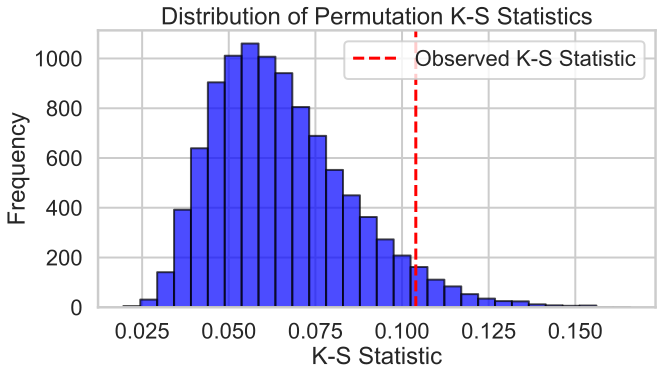

In [228]:
import matplotlib.pyplot as plt

plt.hist(permutation_ks_statistics, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(observed_ks_statistic, color='red', linestyle='--', label='Observed K-S Statistic')

plt.title('Distribution of Permutation K-S Statistics')
plt.xlabel('K-S Statistic')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [282]:
null_hist = go.Histogram(
    x=permutation_ks_statistics,
    nbinsx=30,
    opacity=0.5,
    name='Permutation distribution',
    histnorm='probability density',  # Normalize the histogram
    marker=dict(color='rgba(0, 100, 200, 0.7)')
)

# Add the observed K-S statistic as a vertical line
observed_line = go.Scatter(
    x=[observed_ks_statistic, observed_ks_statistic],
    y=[0, max(np.histogram(permutation_ks_statistics, bins=30)[0])],  
    mode='lines',
    name='Observed K-S Statistic',
    line=dict(color='red', width=2)
)

# Create layout for the plot
layout = go.Layout(
    title={
        'text': 'Distribution of Permutation K-S Statistics',
        'x': 0.45,  # Center the title
        'y': 0.98,  # Add padding above the plot
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')
    },
    legend={
        'font': dict(family='Serif', size=12, color='black')
    },
    xaxis=dict(
       title='K-S Statistic',
       range=[0, 0.160],  # Adjust range to fit your data
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14),
       dtick=0.025,
    ),
    yaxis=dict(
        title='Density',
        range=[0, 1000],  # Adjust range based on your data
        title_font=dict(size=14, family='Serif'),
        tickfont=dict(family='Serif', size=14),
        dtick=0.1,
    ),
    barmode='overlay',
    showlegend=True,
    font=dict(family='Arial, sans-serif'),
    width=700,  # Make the plot wider
    height=400
)

# Create the figure and plot
fig = go.Figure(data=[null_hist, observed_line], layout=layout)
fig.show()
fig.write_html('assets/images/HypothesisPlot.html', auto_open=False)

## Step 5: Framing a Prediction Problem

In [216]:
# TODO

## Step 6: Baseline Model

In [271]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, f1_score


outages_predict = outages.copy()
# Create target feature
outages_predict['Weather_Related'] = outages_predict['CAUSE.CATEGORY'].apply(lambda x: 1 if x == 'severe weather' else 0)

# Split data into features (X) and target (y)

X = outages_predict.drop(columns={'Weather_Related', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'OUTAGE.START', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL'})
y = outages_predict['Weather_Related']


categoric_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

for col in categoric_cols:
    X[col] = X[col].fillna('Unknown')

category_mappings = {col: list(X[col].unique()) for col in categoric_cols}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_encoder = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore',
    categories=[category_mappings[col] for col in categoric_cols]
)


# Define the preprocessor (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
            ('scaler', StandardScaler())  # Scale numeric features
        ]), numeric_cols),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent', fill_value='Unknown')),  # Impute missing values for categorical features
            ('encoder', categorical_encoder)]), categoric_cols)
    ])

# Create a full pipeline with preprocessor and Random Forest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing transformations
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Classifier (RandomForest)
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Cross-validation on training data
cv_train_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')  # 5-fold cross-validation
cv_test_scores = cross_val_score(pipeline, X_test, y_test, cv=6, scoring='f1')  # 5-fold cross-validation

cv_model_scores = cross_val_score(pipeline, X, y, cv=10, scoring='f1')

# Evaluate the model on the test data
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)


print(f"Mean Squared Error: {mse}")

# Print cross-validation and classification report
report = classification_report(y_test, y_pred)
print("Cross-validation Model Scores:", cv_model_scores)
print("Cross-validation Training Scores:", cv_train_scores)
print("Cross-validation Testing Scores:", cv_test_scores)
print(f"Mean Squared Error: {mse}")
print("Classification Report:\n", report)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))




Mean Squared Error: 0.23127035830618892
Cross-validation Model Scores: [0.65 0.47 0.28 0.49 0.18 0.03 0.18 0.22 0.61 0.44]
Cross-validation Training Scores: [0.77 0.78 0.71 0.81 0.77 0.72 0.84 0.84 0.78 0.76]
Cross-validation Testing Scores: [0.71 0.65 0.65 0.63 0.6  0.76]
Mean Squared Error: 0.23127035830618892
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       174
           1       0.71      0.78      0.75       133

    accuracy                           0.77       307
   macro avg       0.77      0.77      0.77       307
weighted avg       0.77      0.77      0.77       307


Confusion Matrix:
 [[132  42]
 [ 29 104]]


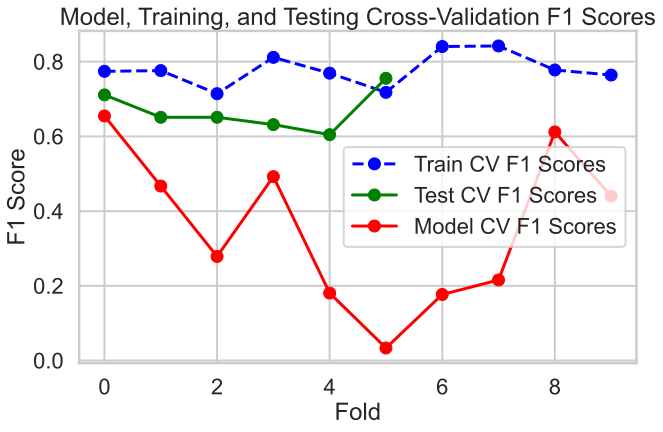

In [272]:
plt.figure(figsize=(10, 6))
plt.plot(cv_train_scores, label='Train CV F1 Scores', marker='o', linestyle='--', color='b')
plt.plot(cv_test_scores, label='Test CV F1 Scores', marker='o', linestyle='-', color='g')
plt.plot(cv_model_scores, label='Model CV F1 Scores', marker='o', linestyle='-', color='r')
plt.title('Model, Training, and Testing Cross-Validation F1 Scores')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [219]:
month_mapping = {
    'MONTH_2.0': 'MONTH_Feb',
    'MONTH_3.0': 'MONTH_Mar',
    'MONTH_4.0': 'MONTH_Apr',
    'MONTH_5.0': 'MONTH_May',
    'MONTH_6.0': 'MONTH_Jun',
    'MONTH_7.0': 'MONTH_Jul',
    'MONTH_8.0': 'MONTH_Aug',
    'MONTH_9.0': 'MONTH_Sep',
    'MONTH_10.0': 'MONTH_Oct',
    'MONTH_11.0': 'MONTH_Nov',
    'MONTH_12.0': 'MONTH_Dec'
}

# Rename Month Columns
outages.rename(columns=month_mapping, inplace=True)


## Step 7: Final Model

### Selecting Features

### Hyperparameter Tuning

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Model Accuracy: 0.7687296416938111
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.74      0.78       174
           1       0.70      0.80      0.75       133

    accuracy                           0.77       307
   macro avg       0.77      0.77      0.77       307
weighted avg       0.78      0.77      0.77       307

Best Model ROC-AUC Score: 0.8534050643851007

Cross-Validation Results:
Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}, Mean F1 Score: 0.7724063887086231
Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimat

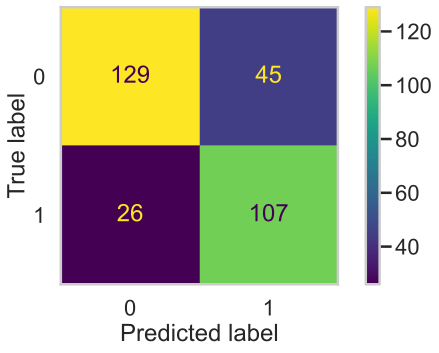

In [273]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

outages_predict = outages.copy()
outages_predict = outages.copy()

outages_predict['Weather_Related'] = outages_predict['CAUSE.CATEGORY'].apply(lambda x: 1 if x == 'severe weather' else 0)
X = outages_predict.drop(columns={'Weather_Related', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'OUTAGE.START', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL'})
y = outages_predict['Weather_Related']

categoric_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

for col in categoric_cols:
    X[col] = X[col].fillna('Unknown')

category_mappings = {col: list(X[col].unique()) for col in categoric_cols}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_encoder = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore',
    categories=[category_mappings[col] for col in categoric_cols]
)

# Define the preprocessor (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
            ('scaler', StandardScaler())  # Scale numeric features
        ]), numeric_cols),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent', fill_value='Unknown')),  # Impute missing values for categorical features
            ('encoder', categorical_encoder)]), categoric_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing transformations
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Classifier (RandomForest)
])

# Define the hyperparameters to tune (targeting the classifier in the pipeline)
param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'classifier__max_depth': [10, 20, 30],  # Maximum depth of each tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV
scoring = {'mean_squared_error': make_scorer(mean_squared_error),'f1': make_scorer(f1_score)}
grid_search = GridSearchCV(pipeline, param_grid,
                           cv=5,  # 5-fold cross-validation 
                           verbose=1,  # Detailed output
                           scoring=scoring,  # Multiple scoring metrics
                           refit='f1'  # Refit the model using the best F1 score
                           )

# Fit the model
grid_search.fit(X_train, y_train)

# Best hyperparameters from GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Evaluate the best model
best_y_pred = best_rf_model.predict(X_test)
best_accuracy = accuracy_score(y_test, best_y_pred)
best_report = classification_report(y_test, best_y_pred)
best_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])

# Print the evaluation results
print("Best Model Accuracy:", best_accuracy)
print("Best Model Classification Report:\n", best_report)
print("Best Model ROC-AUC Score:", best_roc_auc)



### Cross-Validation


Cross-Validation Results:
Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}, Mean F1 Score: 0.7724063887086231
Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}, Mean F1 Score: 0.7738736387753942
Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}, Mean F1 Score: 0.7679256503681742
Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}, Mean F1 Score: 0.7712280876506356
Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}, Mean F1 Score: 0.7730368528646905
Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__mi

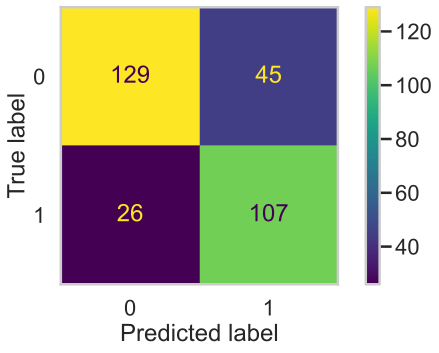

In [274]:
# Optional: Print detailed cross-validation results
print("\nCross-Validation Results:")
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_f1'], cv_results['params']):
    print(f"Params: {params}, Mean F1 Score: {mean_score}")

# Confusion Matrix Display
ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test, y_test)
plt.grid(False)
plt.show()


## Step 8: Fairness Analysis

In [ ]:
# TODO